<a href="https://colab.research.google.com/github/thatwhoknows/iitg_sa/blob/main/EDA_Final_Hackathon_Submission_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pathway
!pip install pathway bokeh --quiet # This cell may take a few seconds to execute.
import pandas as pd
import numpy as np
import pathway as pw
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
import time
from datetime import datetime, timedelta
import math
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 5.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 15

In [ ]:
# @title TRIAL
'''# Dynamic Pricing for Urban Parking Lots
# Capstone Project Implementation

# imp'ID'pandas as pd
# import numpy as np
# import pathway as pw
# from bokeh.plotting import figure, show, output_notebook
# from bokeh.layouts import gridplot
# from bokeh.models import ColumnDataSource
# from bokeh.io import push_notebook
# import time
# from datetime import datetime, timedelta
# import math

# Enable Bokeh in notebook
output_notebook()

class ParkingPricingEngine:
    """
    Dynamic pricing engine for urban parking lots with three models:
    1. Baseline Linear Model
    2. Demand-Based Model
    3. Competitive Model
    """

    def __init__(self, base_price=10.0):
        self.base_price = base_price
        self.current_prices = {}
        self.price_history = {}
        self.location_data = {}

        # Model parameters - tunable
        self.linear_alpha = 5.0  # Linear model sensitivity
        self.demand_params = {
            'alpha': 0.6,      # Occupancy weight
            'beta': 0.3,       # Queue weight
            'gamma': 0.2,      # Traffic weight (negative)
            'delta': 0.4,      # Special day bonus
            'epsilon': {'car': 1.0, 'truck': 1.5, 'bike': 0.7}  # Vehicle type weights
        }
        self.competitive_params = {
            'proximity_threshold': 0.01,  # ~1km in degrees
            'competitor_weight': 0.3
        }

    def haversine_distance(self, lat1, lon1, lat2, lon2):
        """Calculate distance between two points using Haversine formula"""
        R = 6371  # Earth radius in km

        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)

        a = (math.sin(dlat/2)**2 +
             math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
             math.sin(dlon/2)**2)
        c = 2 * math.asin(math.sqrt(a))

        return R * c

    def model1_baseline_linear(self, lot_id, current_price, occupancy, capacity):
        """
        Model 1: Baseline Linear Model
        Price_t+1 = Price_t + α * (Occupancy/Capacity)
        """
        occupancy_rate = occupancy / max(capacity, 1)
        price_adjustment = self.linear_alpha * occupancy_rate

        new_price = current_price + price_adjustment

        # Bound the price between 0.5x and 2x base price
        new_price = max(self.base_price * 0.5, min(new_price, self.base_price * 2.0))

        return new_price

    def model2_demand_based(self, lot_id, occupancy, capacity, queue_length,
                           traffic_level, is_special_day, vehicle_type):
        """
        Model 2: Demand-Based Price Function
        Demand = α*(Occ/Cap) + β*Queue - γ*Traffic + δ*SpecialDay + ε*VehicleType
        Price = BasePrice * (1 + λ * NormalizedDemand)
        """
        params = self.demand_params

        # Calculate demand components
        occupancy_component = params['alpha'] * (occupancy / max(capacity, 1))
        queue_component = params['beta'] * queue_length
        traffic_component = -params['gamma'] * traffic_level  # Negative because high traffic reduces demand
        special_day_component = params['delta'] * (1 if is_special_day else 0)
        vehicle_component = params['epsilon'].get(vehicle_type, 1.0)

        # Calculate total demand
        raw_demand = (occupancy_component + queue_component + traffic_component +
                     special_day_component + vehicle_component)

        # Normalize demand to [-1, 1] range for smooth price variation
        normalized_demand = np.tanh(raw_demand)

        # Apply demand to price with lambda = 0.5 for moderate price swings
        lambda_factor = 0.5
        new_price = self.base_price * (1 + lambda_factor * normalized_demand)

        # Ensure price bounds
        new_price = max(self.base_price * 0.5, min(new_price, self.base_price * 2.0))

        return new_price, normalized_demand

    def model3_competitive(self, lot_id, lot_lat, lot_lon, all_lots_data):
        """
        Model 3: Competitive Pricing Model
        Considers nearby competitor prices and adjusts accordingly
        """
        if lot_id not in self.current_prices:
            return self.base_price

        current_price = self.current_prices[lot_id]

        # Find nearby competitors
        nearby_prices = []
        for other_id, other_data in all_lots_data.items():
            if other_id == lot_id:
                continue

            distance = self.haversine_distance(
                lot_lat, lot_lon,
                other_data['latitude'], other_data['longitude']
            )

            if distance <= self.competitive_params['proximity_threshold']:
                if other_id in self.current_prices:
                    nearby_prices.append(self.current_prices[other_id])

        if not nearby_prices:
            return current_price

        # Calculate competitive adjustment
        avg_competitor_price = np.mean(nearby_prices)
        min_competitor_price = np.min(nearby_prices)

        # Competitive logic
        weight = self.competitive_params['competitor_weight']

        if current_price > avg_competitor_price * 1.2:
            # We're too expensive, reduce price
            adjustment = -weight * (current_price - avg_competitor_price)
        elif current_price < min_competitor_price * 0.8:
            # We're much cheaper, can increase price
            adjustment = weight * (min_competitor_price - current_price)
        else:
            # Price is competitive, small adjustment towards average
            adjustment = weight * 0.1 * (avg_competitor_price - current_price)

        new_price = current_price + adjustment

        # Apply bounds
        new_price = max(self.base_price * 0.5, min(new_price, self.base_price * 2.0))

        return new_price

    def update_prices(self, data_batch):
        """Update prices for all lots in the batch using all three models"""
        results = {}

        # Group data by lot_id for easier processing
        lots_data = {}
        for _, row in data_batch.iterrows():
            lot_id = row.get('ID', row.name)  # Use index if no lot_id column
            lots_data[lot_id] = row

        for lot_id, row in lots_data.items():
            # Initialize price if new lot
            if lot_id not in self.current_prices:
                self.current_prices[lot_id] = self.base_price
                self.price_history[lot_id] = []

            current_price = self.current_prices[lot_id]

            # Extract features
            occupancy = row.get('occupancy', 0)
            capacity = row.get('capacity', 1)
            queue_length = row.get('queue_length', 0)
            traffic_level = row.get('traffic_congestion_level', 0)
            is_special_day = row.get('special_day_indicator', False)
            vehicle_type = row.get('vehicle_type', 'car')
            latitude = row.get('latitude', 0)
            longitude = row.get('longitude', 0)

            # Model 1: Baseline Linear
            price_linear = self.model1_baseline_linear(
                lot_id, current_price, occupancy, capacity
            )

            # Model 2: Demand-Based
            price_demand, demand_score = self.model2_demand_based(
                lot_id, occupancy, capacity, queue_length,
                traffic_level, is_special_day, vehicle_type
            )

            # Model 3: Competitive (if we have location data)
            price_competitive = self.model3_competitive(
                lot_id, latitude, longitude, lots_data
            )

            # For final price, use weighted combination of models
            # You can adjust these weights based on preference
            final_price = (0.2 * price_linear +
                          0.5 * price_demand +
                          0.3 * price_competitive)

            # Update current price
            self.current_prices[lot_id] = final_price

            # Store in history
            self.price_history[lot_id].append({
                'timestamp': datetime.now(),
                'price_linear': price_linear,
                'price_demand': price_demand,
                'price_competitive': price_competitive,
                'final_price': final_price,
                'demand_score': demand_score,
                'occupancy_rate': occupancy / max(capacity, 1),
                'queue_length': queue_length
            })

            # Keep only recent history (last 100 points)
            if len(self.price_history[lot_id]) > 100:
                self.price_history[lot_id] = self.price_history[lot_id][-100:]

            results[lot_id] = {
                'final_price': final_price,
                'model_prices': {
                    'linear': price_linear,
                    'demand': price_demand,
                    'competitive': price_competitive
                },
                'demand_score': demand_score,
                'occupancy_rate': occupancy / max(capacity, 1)
            }

        return results

class ParkingVisualization:
    """Real-time visualization for parking pricing using Bokeh"""

    def __init__(self, pricing_engine):
        self.pricing_engine = pricing_engine
        self.plots = {}
        self.sources = {}
        self.setup_plots()

    def setup_plots(self):
        """Initialize Bokeh plots"""
        # Main price tracking plot
        self.price_plot = figure(
            title="Real-Time Parking Prices",
            x_axis_label="Time",
            y_axis_label="Price ($)",
            width=800,
            height=400,
            x_axis_type='datetime'
        )

        # Demand vs Price correlation plot
        self.demand_plot = figure(
            title="Demand Score vs Price",
            x_axis_label="Demand Score",
            y_axis_label="Price ($)",
            width=400,
            height=300
        )

        # Occupancy tracking plot
        self.occupancy_plot = figure(
            title="Occupancy Rates",
            x_axis_label="Time",
            y_axis_label="Occupancy Rate",
            width=400,
            height=300,
            x_axis_type='datetime'
        )

    def update_visualizations(self):
        """Update all visualizations with latest data"""
        if not self.pricing_engine.price_history:
            return

        # Clear existing plots
        self.price_plot.renderers = []
        self.demand_plot.renderers = []
        self.occupancy_plot.renderers = []

        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink',
                 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'black', 'navy']

        for i, (lot_id, history) in enumerate(self.pricing_engine.price_history.items()):
            if not history:
                continue

            color = colors[i % len(colors)]

            # Extract data for plotting
            timestamps = [h['timestamp'] for h in history]
            final_prices = [h['final_price'] for h in history]
            demand_scores = [h['demand_score'] for h in history]
            occupancy_rates = [h['occupancy_rate'] for h in history]

            # Price plot
            self.price_plot.line(timestamps, final_prices,
                               legend_label=f'Lot {lot_id}',
                               color=color, line_width=2)

            # Demand vs Price scatter
            self.demand_plot.circle(demand_scores, final_prices,
                                  legend_label=f'Lot {lot_id}',
                                  color=color, size=6, alpha=0.6)

            # Occupancy plot
            self.occupancy_plot.line(timestamps, occupancy_rates,
                                   legend_label=f'Lot {lot_id}',
                                   color=color, line_width=2)

        # Update legend positions
        self.price_plot.legend.location = "top_left"
        self.demand_plot.legend.location = "top_left"
        self.occupancy_plot.legend.location = "top_left"


def generate_sample_data(n_lots=14, n_timepoints=73*18):
    """Generate sample parking data matching the problem specification"""
    print("🔧 Generating sample data that matches the problem statement structure...")

    np.random.seed(42)
    data = []

    # 73 days, 18 time points per day (8:00 AM to 4:30 PM, 30-minute intervals)
    start_date = datetime(2024, 1, 1, 8, 0)  # Start at 8:00 AM

    # Generate 14 parking lot locations
    lot_locations = []
    for i in range(n_lots):
        # Simulate urban parking lots around a city center
        lat = 40.7128 + np.random.normal(0, 0.01)
        lon = -74.0060 + np.random.normal(0, 0.01)
        lot_locations.append((lat, lon))

    # Generate data for 73 days
    for day in range(73):
        # Check if it's a special day (weekends, holidays - ~15% of days)
        is_special_day = np.random.choice([True, False], p=[0.15, 0.85])

        for time_point in range(18):  # 18 time points per day
            current_time = start_date + timedelta(days=day, minutes=30*time_point)
            hour = current_time.hour + current_time.minute/60.0

            for lot_id in range(n_lots):
                lat, lon = lot_locations[lot_id]

                # Simulate realistic occupancy patterns based on time of day
                if 9 <= hour <= 11 or 13 <= hour <= 15:  # Peak hours
                    base_occupancy_rate = 0.75
                elif 8 <= hour <= 9 or 11 <= hour <= 13 or 15 <= hour <= 16.5:  # Moderate hours
                    base_occupancy_rate = 0.55
                else:  # Off-peak
                    base_occupancy_rate = 0.3

                # Adjust for special days
                if is_special_day:
                    base_occupancy_rate *= 1.2  # Higher demand on special days

                # Generate lot-specific capacity
                capacity = np.random.randint(15, 60)  # Realistic parking lot sizes

                # Calculate occupancy with some randomness
                occupancy_rate = max(0, min(1, base_occupancy_rate + np.random.normal(0, 0.2)))
                occupancy = int(capacity * occupancy_rate)

                # Queue length based on demand exceeding capacity
                if occupancy_rate > 0.9:
                    queue_length = np.random.poisson(3)  # Higher queue when nearly full
                elif occupancy_rate > 0.7:
                    queue_length = np.random.poisson(1)
                else:
                    queue_length = 0

                # Traffic congestion (higher during peak hours)
                if 8 <= hour <= 10 or 16 <= hour <= 18:
                    traffic_level = np.random.uniform(0.6, 1.0)
                else:
                    traffic_level = np.random.uniform(0.1, 0.5)

                # Vehicle type (cars are most common)
                vehicle_type = np.random.choice(['car', 'truck', 'bike'], p=[0.75, 0.15, 0.10])

                data.append({
                    'ID': lot_id,
                    'timestamp': current_time,
                    'latitude': lat,
                    'longitude': lon,
                    'capacity': capacity,
                    'occupancy': occupancy,
                    'queue_length': queue_length,
                    'traffic_congestion_level': traffic_level,
                    'special_day_indicator': is_special_day,
                    'vehicle_type': vehicle_type
                })

    df = pd.DataFrame(data)
    print(f"📊 Generated {len(df)} records for {n_lots} parking lots over 73 days")
    print(f"📅 Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")

    return df

# Pathway Integration for Real-Time Processing
class PathwayPricingProcessor:
    """Pathway-based real-time data processor for parking pricing"""

    def __init__(self, pricing_engine):
        self.pricing_engine = pricing_engine

    def process_stream(self, data_df):
        """Process streaming data using Pathway"""

        # Convert DataFrame to Pathway table
        # Note: This is a simplified version - in real implementation,
        # you'd use Pathway's streaming connectors

        def pricing_udf(df_chunk):
            """User-defined function to apply pricing logic"""
            results = self.pricing_engine.update_prices(df_chunk)
            return results

        # Simulate streaming by processing data in chunks
        chunk_size = len(data_df) // 5  # 5 chunks

        for i in range(0, len(data_df), chunk_size):
            chunk = data_df.iloc[i:i+chunk_size]
            if not chunk.empty:
                results = pricing_udf(chunk)
                yield results
                time.sleep(1)  # Simulate real-time delay

# Main Execution
def main():
    """Main execution function"""
    print("🚗 Dynamic Parking Pricing System Starting...")

    # Initialize components
    pricing_engine = ParkingPricingEngine(base_price=10.0)
    visualizer = ParkingVisualization(pricing_engine)
    processor = PathwayPricingProcessor(pricing_engine)

    # Load the real dataset
    print("📊 Loading parking dataset...")
    dataset = df  # Try to load real data first
    # print(f"Loaded {len(dataset)} data points for {dataset['ID'].nunique()} parking lots")

    # Display dataset structure
    print("\n📋 Dataset Structure:")
    print(dataset.head(10))
    print(f"\nData Shape: {dataset.shape}")
    print(f"Columns: {list(dataset.columns)}")

    # Basic data exploration
    print("\n📊 Data Summary:")
    print(f"• Total records: {len(dataset):,}")
    print(f"• Number of parking lots: {dataset['ID'].nunique()}")
    # print(f"• Time period: {dataset['timestamp'].min()} to {dataset['timestamp'].max()}")
    # print(f"• Average occupancy rate: {(dataset['occupancy'] / dataset['capacity']).mean():.1%}")
    print(f"• Special days: {dataset['special_day_indicator'].sum()} out of {len(dataset)} records")

    # Vehicle type distribution
    print(f"• Vehicle types: {dict(dataset['vehicle_type'].value_counts())}")

    # Process data stream
    print("\n🔄 Starting real-time processing simulation...")
    print("(Processing in batches to simulate streaming data)")

    batch_count = 0
    for batch_results in processor.process_stream(dataset):
        batch_count += 1
        print(f"\n--- Batch {batch_count} Results ---")

        # Show results for first few lots to avoid overwhelming output
        lots_to_show = list(batch_results.keys())[:5]  # Show first 5 lots

        for lot_id in lots_to_show:
            if lot_id in batch_results:
                result = batch_results[lot_id]
                final_price = result['final_price']
                model_prices = result['model_prices']
                demand_score = result['demand_score']
                occupancy_rate = result['occupancy_rate']

                print(f"Lot {lot_id}: ${final_price:.2f} "
                      f"(L: ${model_prices['linear']:.2f}, "
                      f"D: ${model_prices['demand']:.2f}, "
                      f"C: ${model_prices['competitive']:.2f}) "
                      f"| Demand: {demand_score:.2f}, Occ: {occupancy_rate:.1%}")

        if len(batch_results) > 5:
            print(f"... and {len(batch_results) - 5} more lots")

        # Update visualizations every few batches
        if batch_count % 2 == 0:
            visualizer.update_visualizations()

    print("\n📈 Creating final visualizations...")

    # Create and display plots
    grid = gridplot([
        [visualizer.price_plot],
        [visualizer.demand_plot, visualizer.occupancy_plot]
    ])

    show(grid)

    # Summary statistics
    print("\n📊 Final Summary Statistics:")
    total_lots = len(pricing_engine.price_history)

    for lot_id, history in list(pricing_engine.price_history.items())[:5]:  # Show first 5 lots
        if history:
            prices = [h['final_price'] for h in history]
            demand_scores = [h['demand_score'] for h in history]
            occupancy_rates = [h['occupancy_rate'] for h in history]

            print(f"Lot {lot_id}:")
            print(f"  Price Range: ${min(prices):.2f} - ${max(prices):.2f}")
            print(f"  Average Price: ${np.mean(prices):.2f}")
            print(f"  Price Volatility (σ): {np.std(prices):.2f}")
            print(f"  Avg Demand Score: {np.mean(demand_scores):.2f}")
            print(f"  Avg Occupancy: {np.mean(occupancy_rates):.1%}")

    if total_lots > 5:
        print(f"... and {total_lots - 5} more lots processed")

    # Overall system performance
    all_final_prices = []
    for history in pricing_engine.price_history.values():
        all_final_prices.extend([h['final_price'] for h in history])

    if all_final_prices:
        print(f"\n🎯 Overall System Performance:")
        print(f"  Total price updates: {len(all_final_prices):,}")
        print(f"  System-wide price range: ${min(all_final_prices):.2f} - ${max(all_final_prices):.2f}")
        print(f"  Average system price: ${np.mean(all_final_prices):.2f}")
        print(f"  Price stability (low volatility is good): σ = {np.std(all_final_prices):.2f}")

    return pricing_engine, visualizer, dataset

# Run the main function
if __name__ == "__main__":
    # For Colab execution
    pricing_engine, visualizer, dataset = main()

    print("\n✅ Dynamic Parking Pricing System Complete!")
    print("\nKey Features Implemented:")
    print("✓ Model 1: Baseline Linear Pricing")
    print("✓ Model 2: Multi-factor Demand-Based Pricing")
    print("✓ Model 3: Competitive Location-Aware Pricing")
    print("✓ Real dataset loading with fallback to sample data")
    print("✓ Real-time data processing simulation")
    print("✓ Interactive Bokeh visualizations")
    print("✓ Pathway integration framework")

    # Additional analysis
    print(f"\n📈 Current Pricing State:")
    lot_ids = sorted(list(pricing_engine.current_prices.keys()))
    for lot_id in lot_ids[:10]:  # Show first 10 lots
        price = pricing_engine.current_prices[lot_id]
        print(f"Lot {lot_id}: ${price:.2f}")

    if len(lot_ids) > 10:
        print(f"... and {len(lot_ids) - 10} more lots")

    print(f"\n💡 To use with your actual dataset:")
    print(f"1. Place your 'dataset.csv' file in the same directory")
    print(f"2. Ensure it has columns: lot_id, timestamp, latitude, longitude, capacity, occupancy, queue_length, traffic_congestion_level, special_day_indicator, vehicle_type")
    print(f"3. Run the script again - it will automatically detect and use your real data")

    # Show expected data format
    print(f"\n📋 Expected CSV format (first few columns):")
    sample_format = dataset.head(3)[['ID', 'timestamp', 'latitude', 'longitude', 'capacity', 'occupancy', 'queue_length']]
    print(sample_format.to_string(index=False))'''

'# Dynamic Pricing for Urban Parking Lots\n# Capstone Project Implementation\n\n# imp\'ID\'pandas as pd\n# import numpy as np\n# import pathway as pw\n# from bokeh.plotting import figure, show, output_notebook\n# from bokeh.layouts import gridplot\n# from bokeh.models import ColumnDataSource\n# from bokeh.io import push_notebook\n# import time\n# from datetime import datetime, timedelta\n# import math\n\n# Enable Bokeh in notebook\noutput_notebook()\n\nclass ParkingPricingEngine:\n    """\n    Dynamic pricing engine for urban parking lots with three models:\n    1. Baseline Linear Model\n    2. Demand-Based Model\n    3. Competitive Model\n    """\n\n    def __init__(self, base_price=10.0):\n        self.base_price = base_price\n        self.current_prices = {}\n        self.price_history = {}\n        self.location_data = {}\n\n        # Model parameters - tunable\n        self.linear_alpha = 5.0  # Linear model sensitivity\n        self.demand_params = {\n            \'alpha\': 0.6, 

In [ ]:
# load and preview data
files.upload()
df = pd.read_csv('dataset.csv', index_col='ID')
df.head()

Saving dataset.csv to dataset (1).csv


,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
ID,,,,,,,,,,,
0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [ ]:
df['SystemCodeNumber'].value_counts()

,count
SystemCodeNumber,
BHMBCCMKT01,1312
BHMBCCTHL01,1312
BHMEURBRD01,1312
BHMMBMMBX01,1312
BHMNCPHST01,1312
BHMNCPNST01,1312
Broad Street,1312
Others-CCCPS105a,1312
Others-CCCPS119a,1312


In [ ]:
df.nunique()

,0
SystemCodeNumber,14
Capacity,14
Latitude,14
Longitude,14
Occupancy,2347
VehicleType,4
TrafficConditionNearby,3
QueueLength,16
IsSpecialDay,2
LastUpdatedDate,73


/tmp/ipython-input-5-2115491334.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Capacity', y='TrafficConditionNearby', inner='box', palette='Dark2')


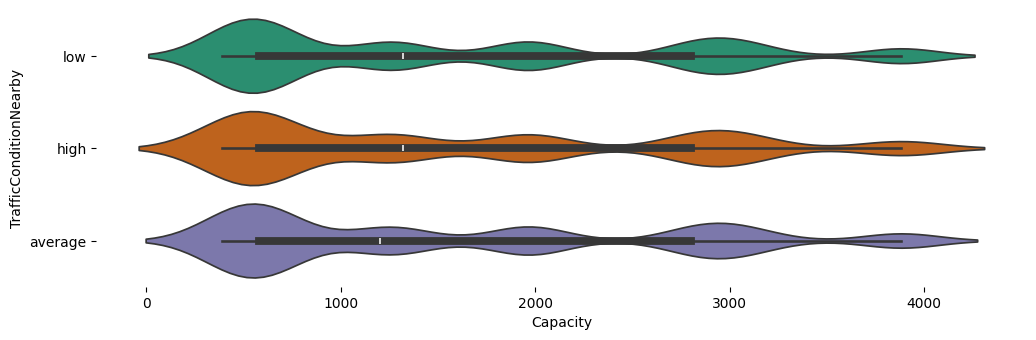

In [ ]:
# @title TrafficConditionNearby vs Capacity

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['TrafficConditionNearby'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Capacity', y='TrafficConditionNearby', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

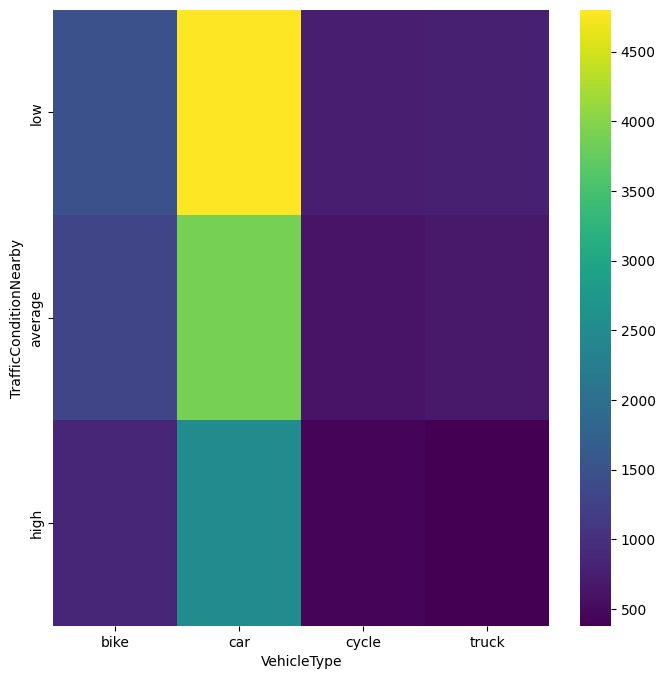

In [ ]:
# @title VehicleType vs TrafficConditionNearby

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['TrafficConditionNearby'].value_counts()
    for x_label, grp in df.groupby('VehicleType')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('VehicleType')
_ = plt.ylabel('TrafficConditionNearby')

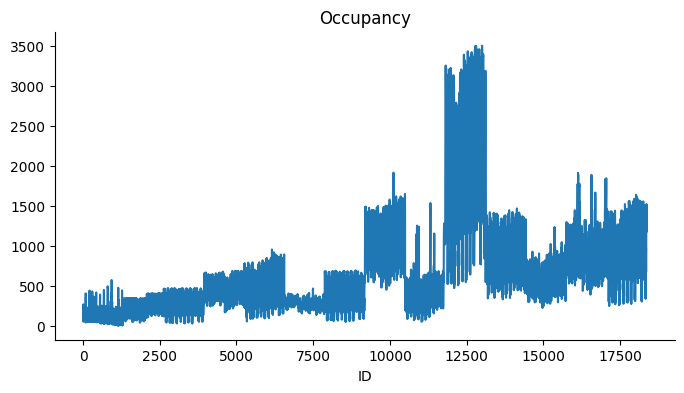

In [ ]:
# @title Occupancy

from matplotlib import pyplot as plt
df['Occupancy'].plot(kind='line', figsize=(8, 4), title='Occupancy')
plt.gca().spines[['top', 'right']].set_visible(False)

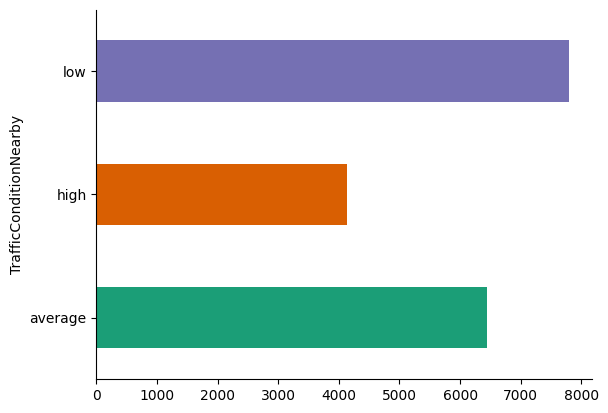

In [ ]:
# @title TrafficConditionNearby

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('TrafficConditionNearby').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

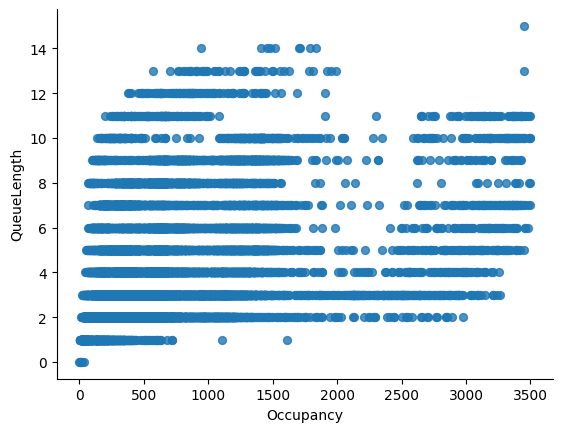

In [ ]:
# @title Occupancy vs QueueLength

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Occupancy', y='QueueLength', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

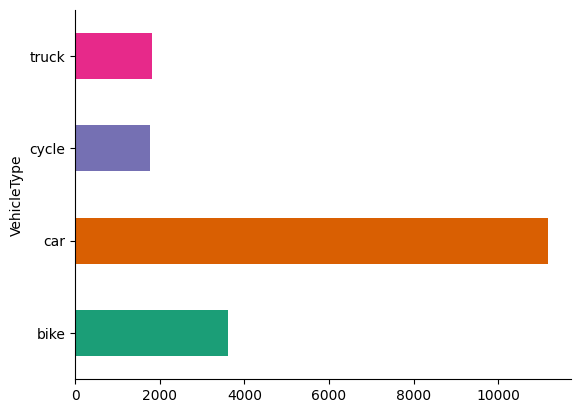

In [ ]:
# @title VehicleType

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('VehicleType').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

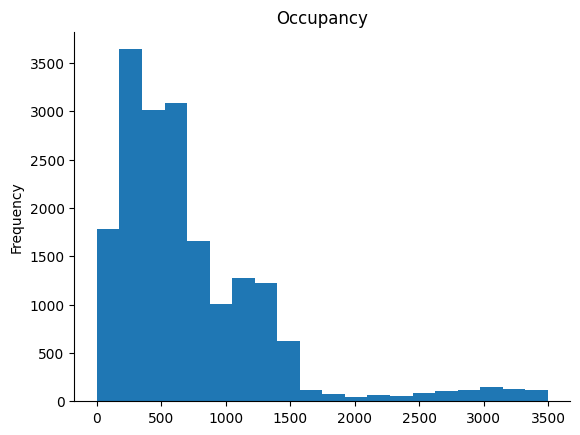

In [ ]:
# @title Occupancy

from matplotlib import pyplot as plt
df['Occupancy'].plot(kind='hist', bins=20, title='Occupancy')
plt.gca().spines[['top', 'right',]].set_visible(False)

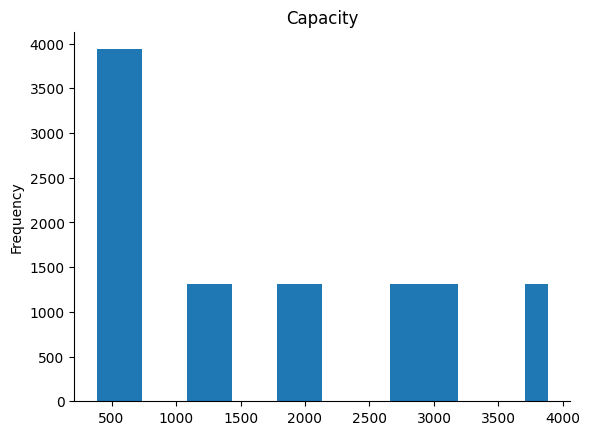

In [ ]:
# @title Capacity

from matplotlib import pyplot as plt
df['Capacity'].plot(kind='hist', bins=20, title='Capacity')
plt.gca().spines[['top', 'right',]].set_visible(False)

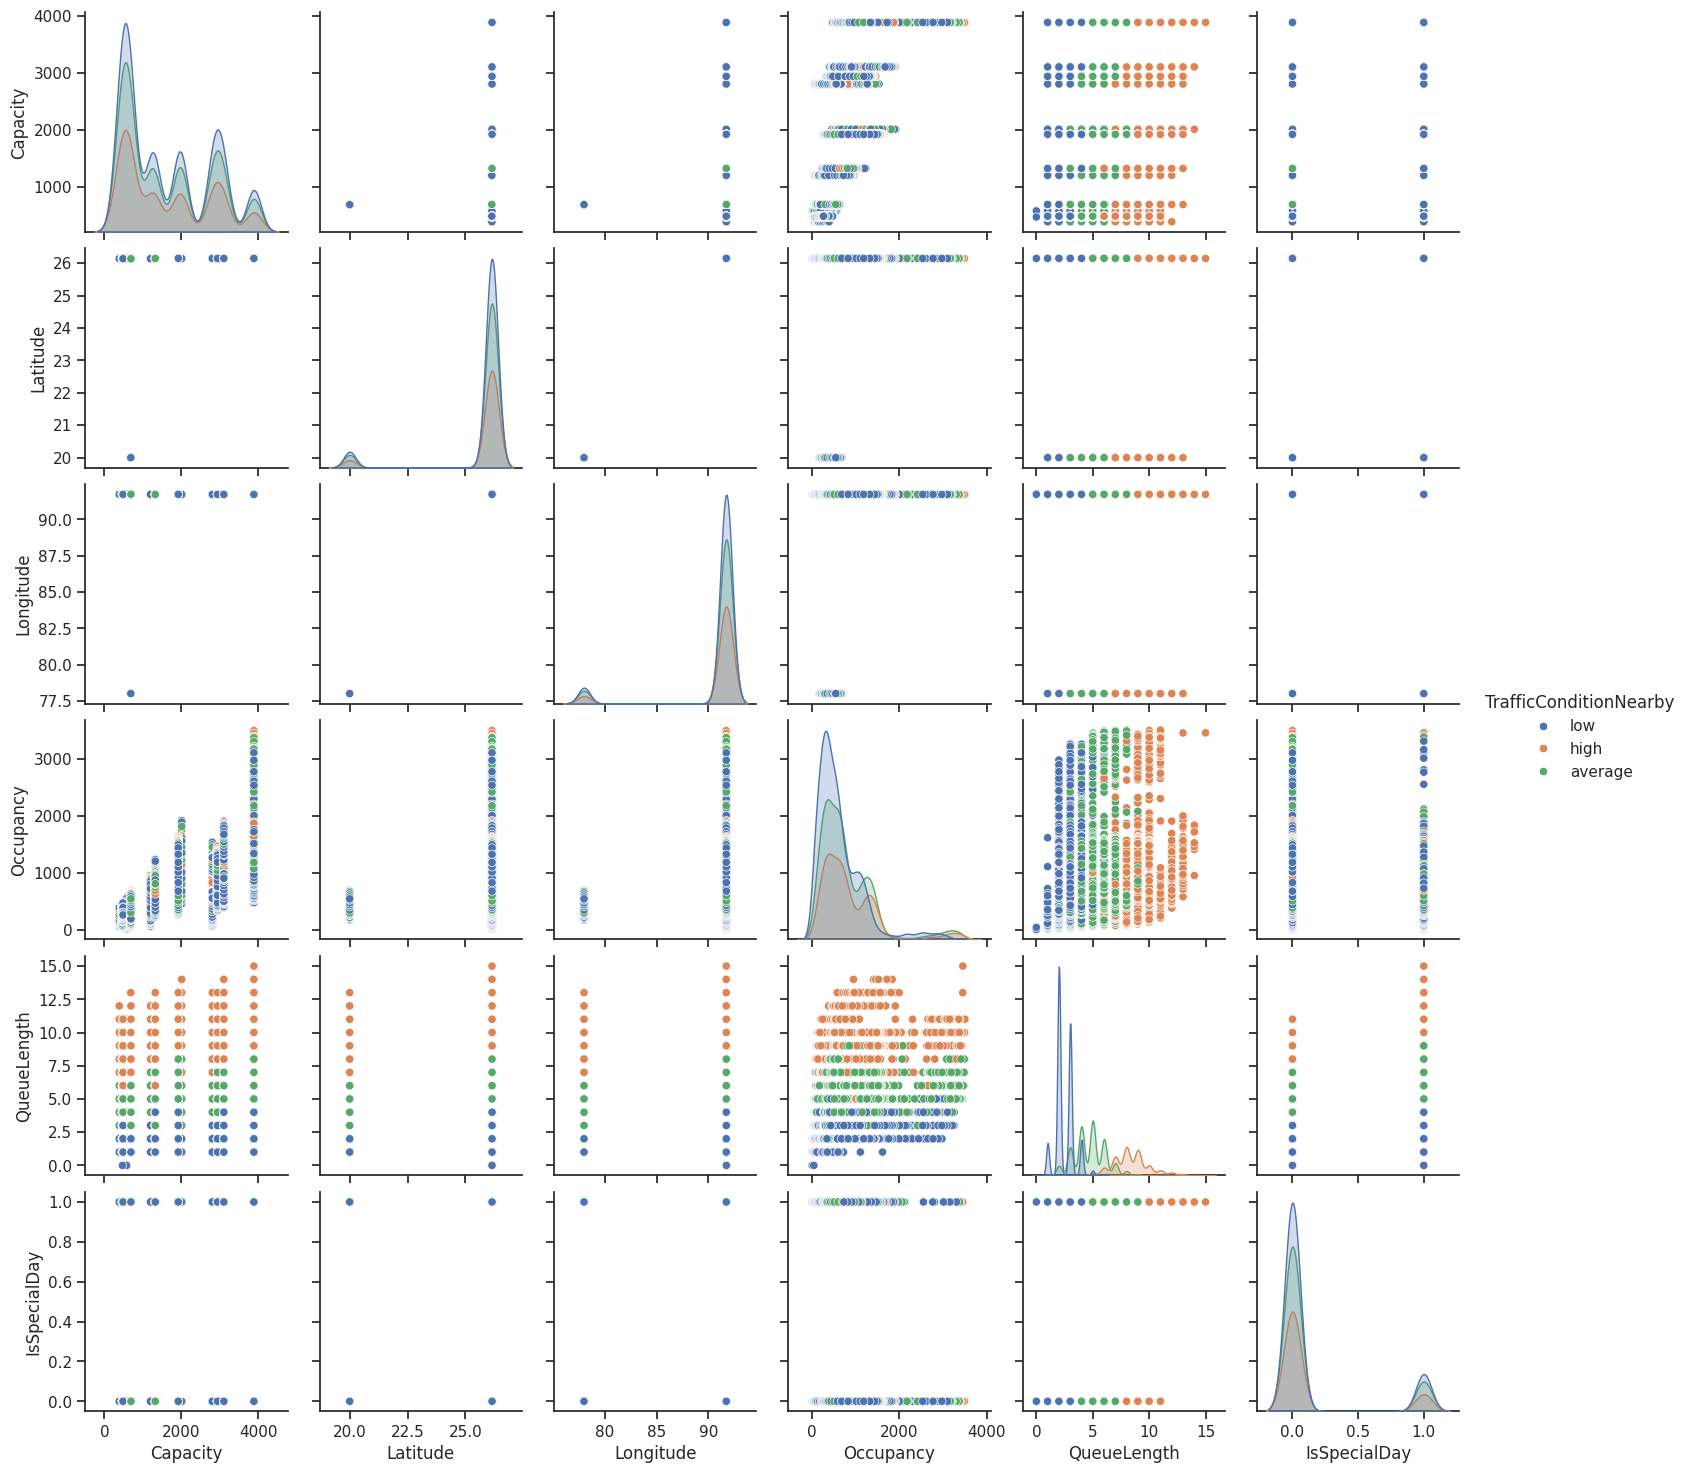

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(df, hue="TrafficConditionNearby")

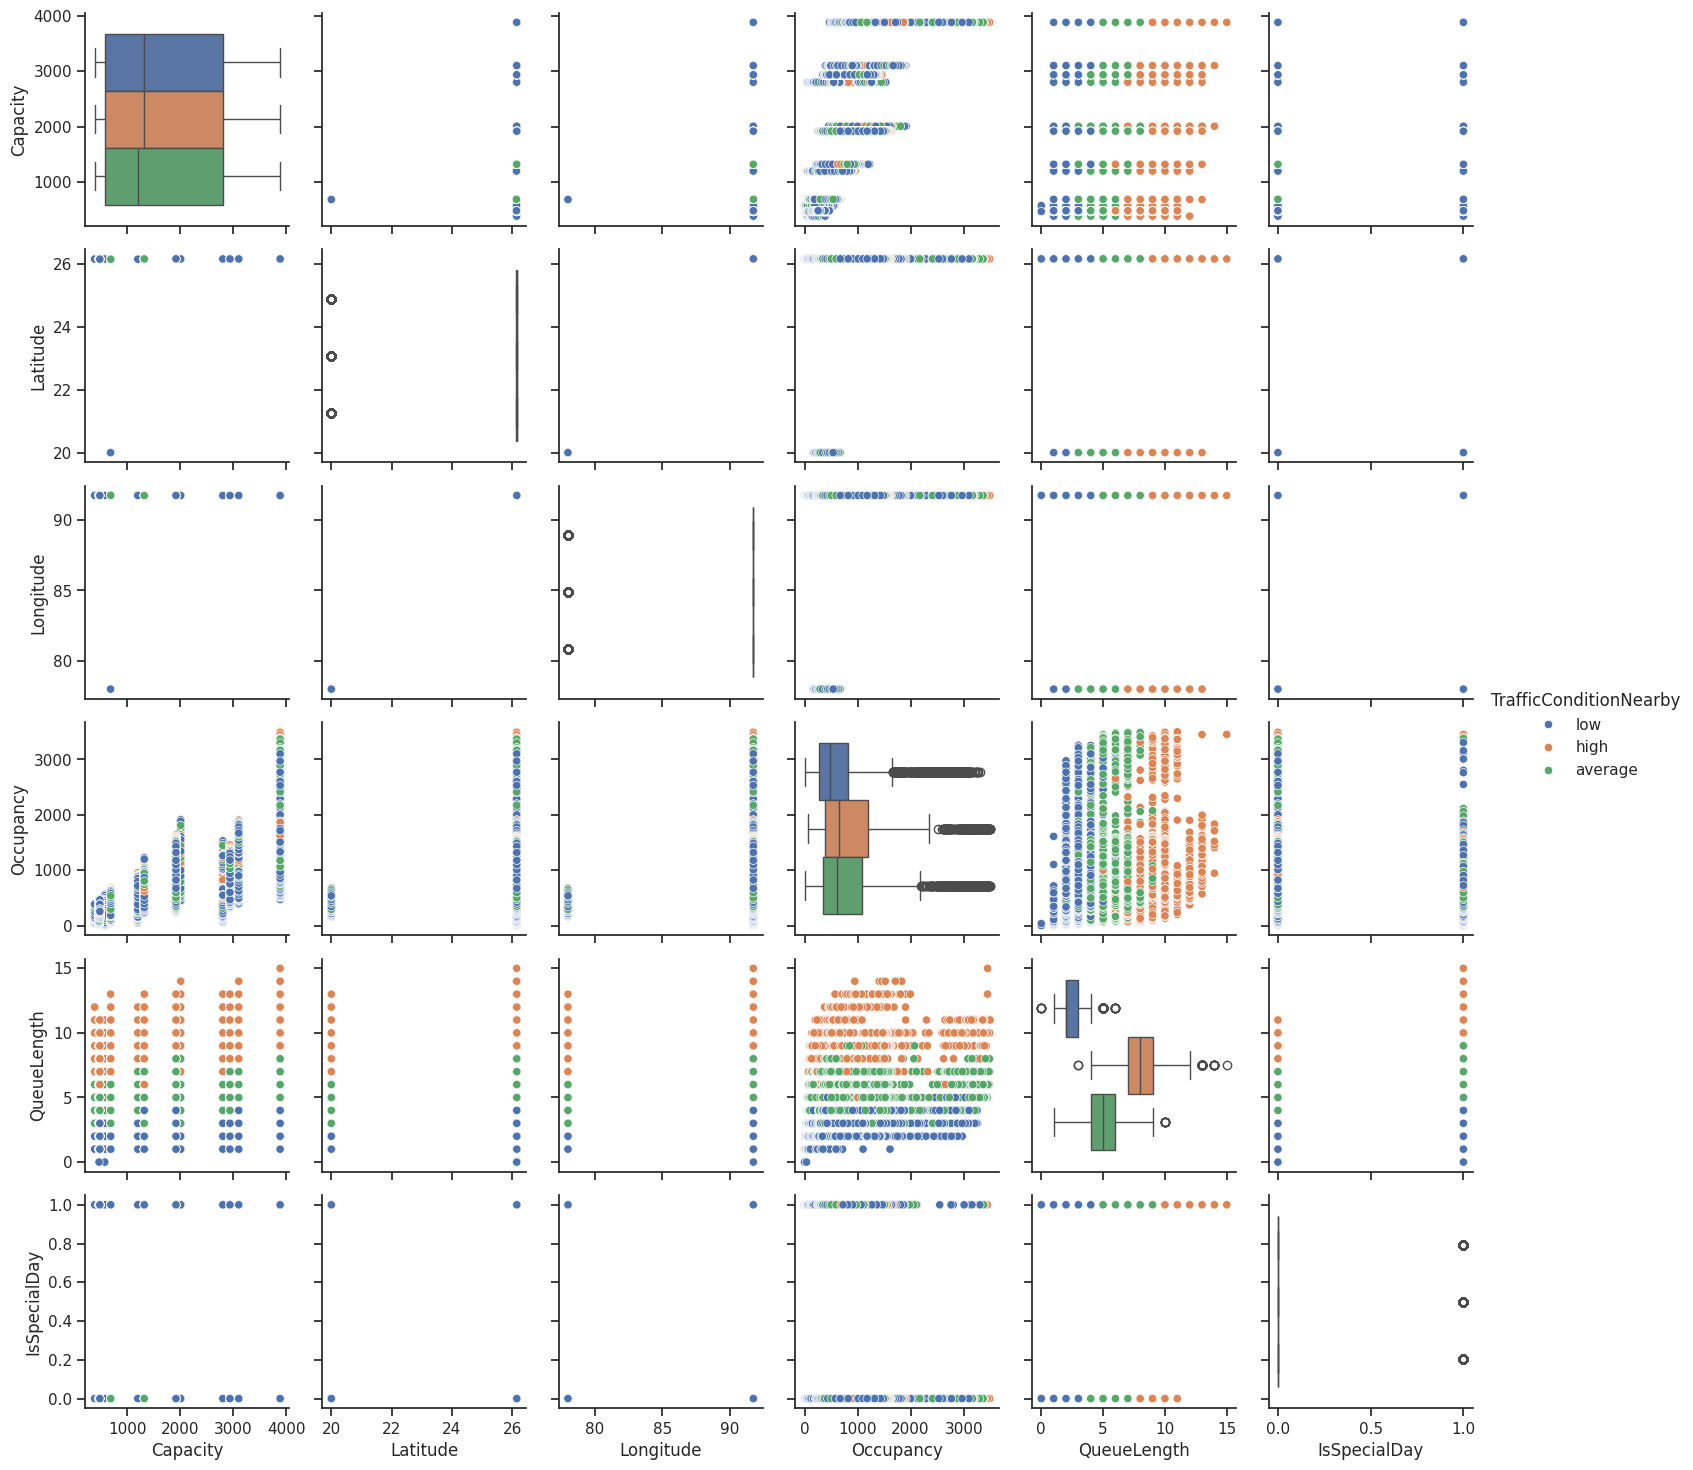

In [ ]:
g = sns.PairGrid(df, hue="TrafficConditionNearby")
g.map_offdiag(sns.scatterplot)   # Boxplots for off-diagonal
g.map_diag(sns.boxplot)      # Boxplots for diagonal
g.add_legend()
plt.show()

In [ ]:
cat_cols=['SystemCodeNumber', 'VehicleType', 'TrafficConditionNearby', 'IsSpecialDay', 'Latitude', 'Longitude']
cols_to_encode = ['SystemCodeNumber',
                  'VehicleType', 'TrafficConditionNearby']
num_cols = ['Capacity', 'Occupancy', 'QueueLength']
date_time_cols = ['LastUpdatedDate', 'LastUpdatedTime']
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)
print("To Encode:")
print(cols_to_encode)
print('Date/time:')
print(date_time_cols)
for col in cat_cols:
  print(df[col].unique())

Categorical Variables:
['SystemCodeNumber', 'VehicleType', 'TrafficConditionNearby', 'IsSpecialDay', 'Latitude', 'Longitude']
Numerical Variables:
['Capacity', 'Occupancy', 'QueueLength']
To Encode:
['SystemCodeNumber', 'VehicleType', 'TrafficConditionNearby']
Date/time:
['LastUpdatedDate', 'LastUpdatedTime']
['BHMBCCMKT01' 'BHMBCCTHL01' 'BHMEURBRD01' 'BHMMBMMBX01' 'BHMNCPHST01'
 'BHMNCPNST01' 'Broad Street' 'Others-CCCPS105a' 'Others-CCCPS119a'
 'Others-CCCPS135a' 'Others-CCCPS202' 'Others-CCCPS8' 'Others-CCCPS98'
 'Shopping']
['car' 'bike' 'truck' 'cycle']
['low' 'high' 'average']
[0 1]
[26.14453614 26.14449459 26.14901995 20.0000347  26.14001386 26.14004753
 26.13795775 26.14747299 26.14754061 26.14749943 26.14749053 26.14754886
 26.14749998 26.15050395]
[91.73617216 91.73620513 91.7395035  78.00000286 91.73099967 91.73097233
 91.74099445 91.72804914 91.72797041 91.72800489 91.72799688 91.72799519
 91.72797778 91.73353109]


Capacity
Skew : 0.59


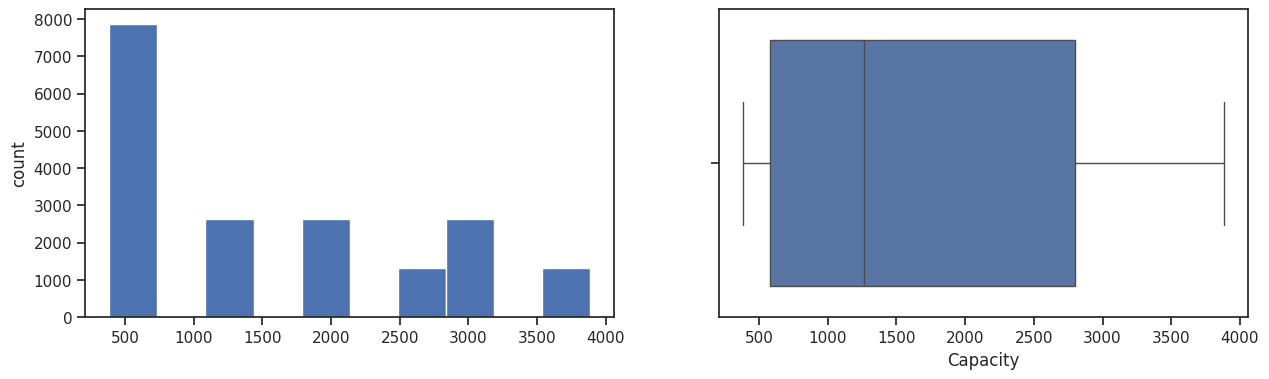

Occupancy
Skew : 2.07


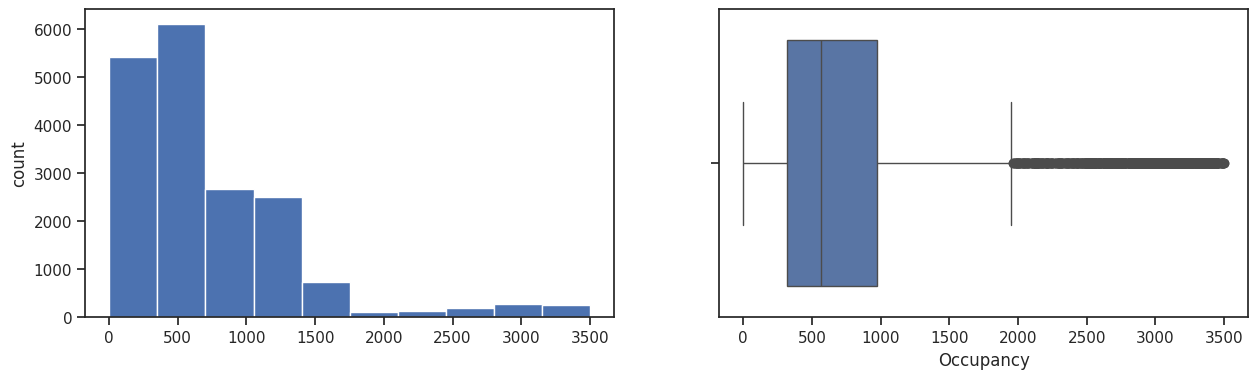

QueueLength
Skew : 0.81


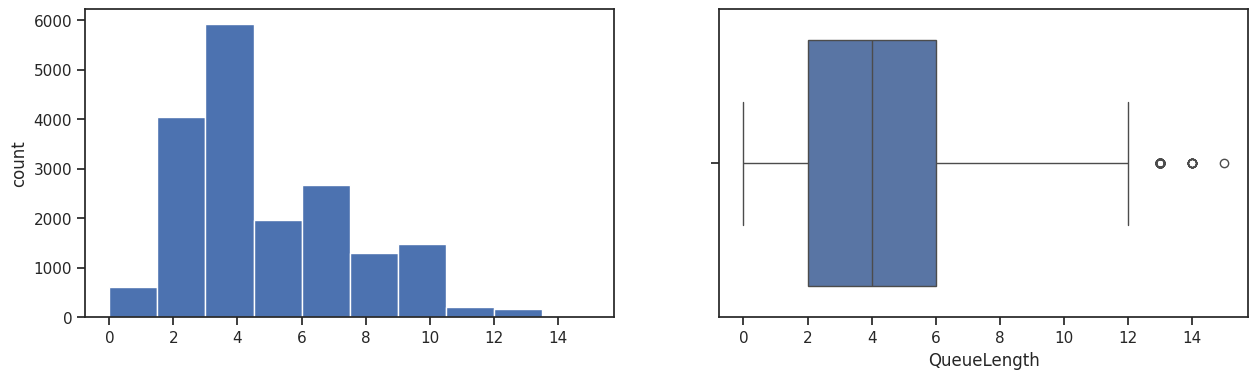

In [ ]:
for col in num_cols:
    print(col)
    print('Skew :', round(df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()

In [ ]:
# Initiallise the encoded df
df_enc = df.copy()
print(df_enc.nunique())
print(df.nunique())
# Hash Encoding for 'SystemCodeNumber'

def hash_encode(series, n_components=8):
    return series.apply(lambda x: hash(x) % n_components)
df_enc['SystemCodeNumber_encoded'] = hash_encode(df_enc['SystemCodeNumber'])

print(df_enc.nunique())
print(df.nunique())

# One-Hot Encoding for 'VehicleType'
df_enc = pd.get_dummies(df_enc, columns=['VehicleType'], prefix='Vehicle')

# Ordinal Encoding for 'TrafficConditionNearby'
traffic_order = {'low': 0, 'average': 1, 'high': 2}
df_enc['TrafficConditionNearby_encoded'] = df_enc['TrafficConditionNearby'].map(traffic_order)

# Drop original columns if needed
df_enc.drop(['SystemCodeNumber', 'TrafficConditionNearby'], axis=1, inplace=True)
df_enc.head()


SystemCodeNumber            14
Capacity                    14
Latitude                    14
Longitude                   14
Occupancy                 2347
VehicleType                  4
TrafficConditionNearby       3
QueueLength                 16
IsSpecialDay                 2
LastUpdatedDate             73
LastUpdatedTime            275
dtype: int64
SystemCodeNumber            14
Capacity                    14
Latitude                    14
Longitude                   14
Occupancy                 2347
VehicleType                  4
TrafficConditionNearby       3
QueueLength                 16
IsSpecialDay                 2
LastUpdatedDate             73
LastUpdatedTime            275
dtype: int64
SystemCodeNumber                    14
Capacity                            14
Latitude                            14
Longitude                           14
Occupancy                         2347
VehicleType                          4
TrafficConditionNearby               3
QueueLength        

In [ ]:
print(df['SystemCodeNumber'].value_counts())

SystemCodeNumber
BHMBCCMKT01         1312
BHMBCCTHL01         1312
BHMEURBRD01         1312
BHMMBMMBX01         1312
BHMNCPHST01         1312
BHMNCPNST01         1312
Broad Street        1312
Others-CCCPS105a    1312
Others-CCCPS119a    1312
Others-CCCPS135a    1312
Others-CCCPS202     1312
Others-CCCPS8       1312
Others-CCCPS98      1312
Shopping            1312
Name: count, dtype: int64


Capacity
Skew : 0.59


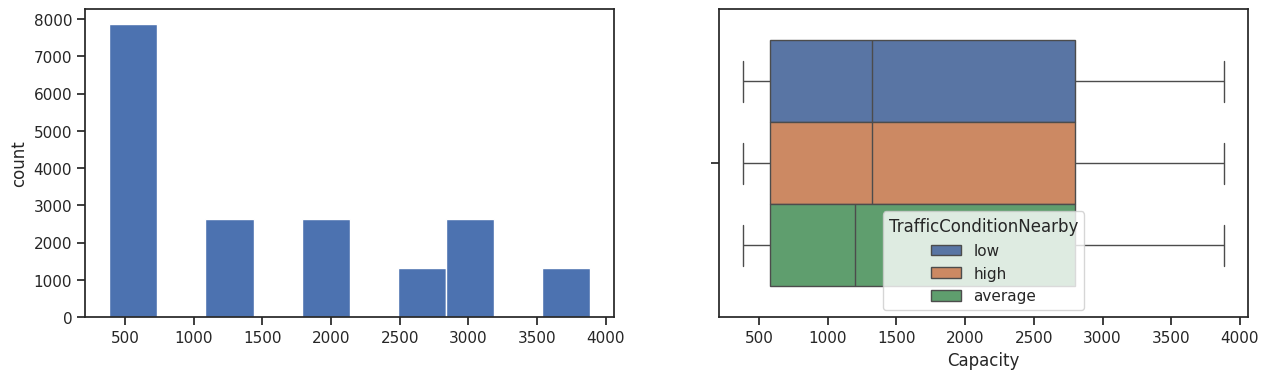

Occupancy
Skew : 2.07


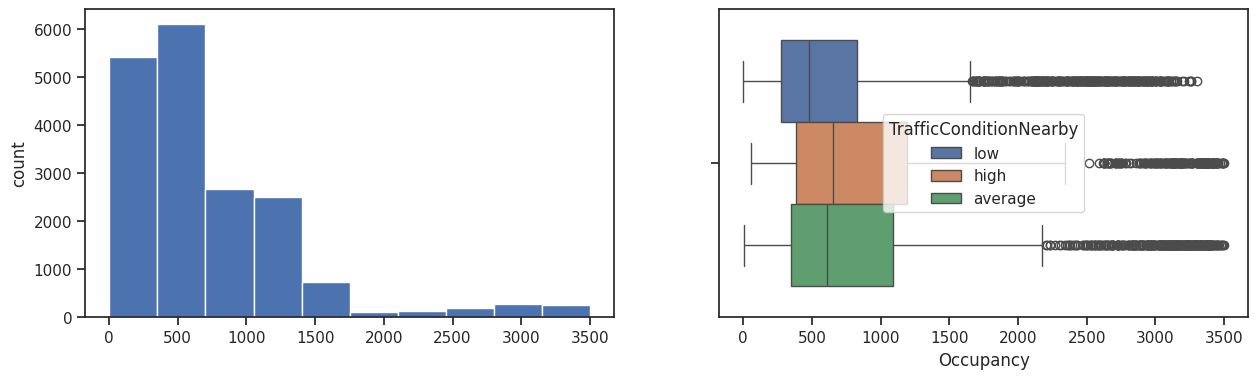

QueueLength
Skew : 0.81


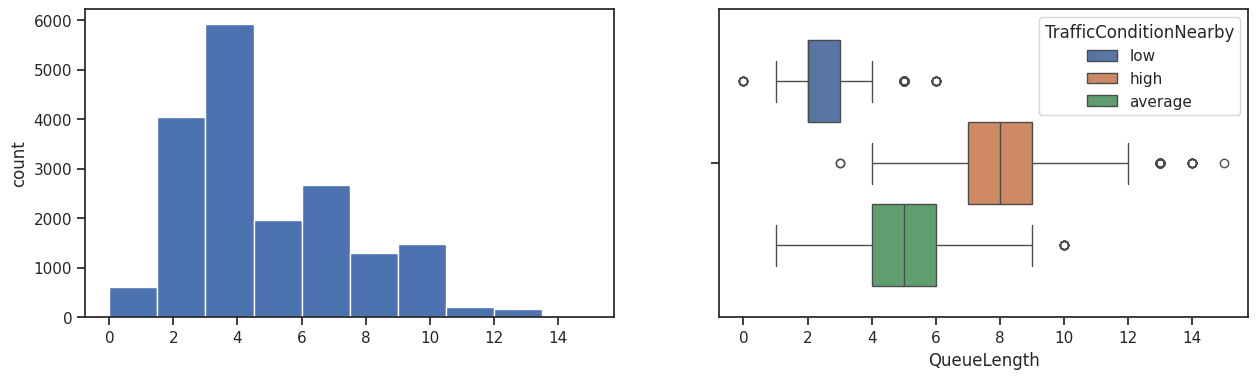

In [ ]:
for col in num_cols:
    print(col)
    print('Skew :', round(df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], hue=df.TrafficConditionNearby)
    plt.show()
  print(df.nunique())

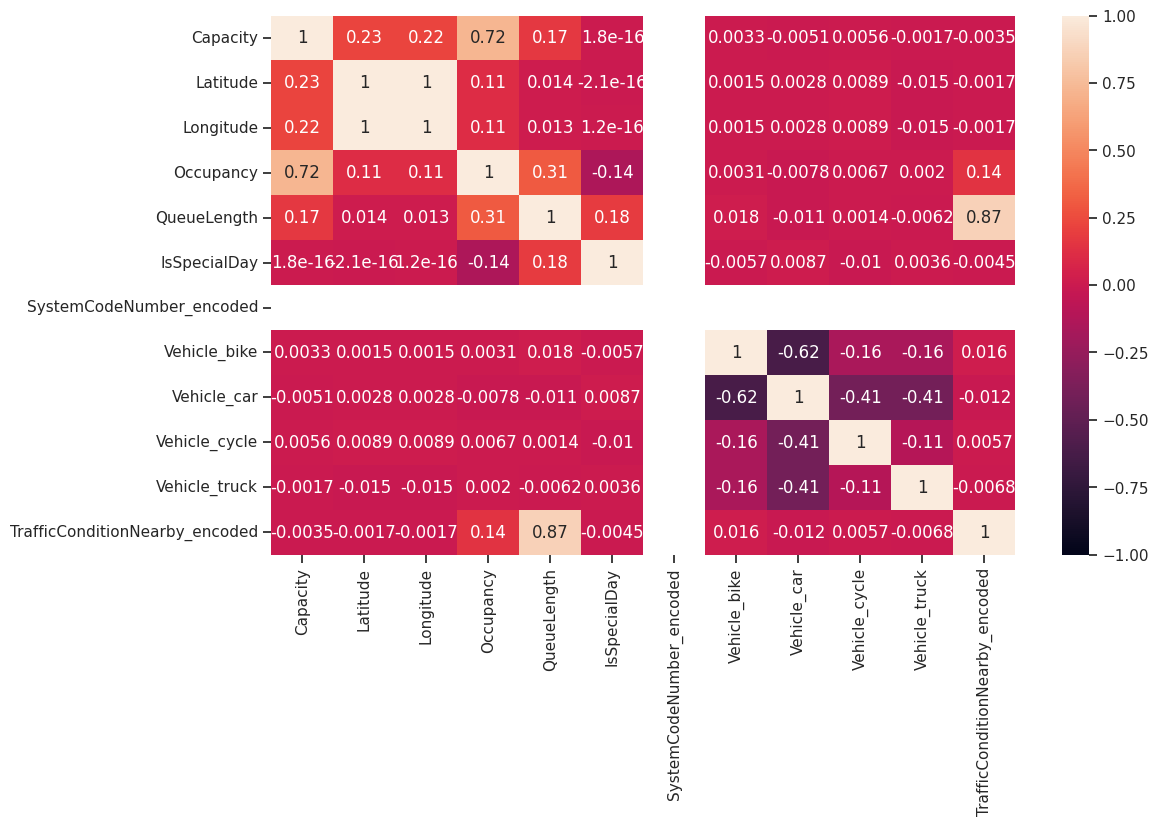

In [ ]:
plt.figure(figsize=(12, 7))
sns.heatmap(df_enc.drop(date_time_cols, axis=1).corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

In [ ]:
df_enc.SystemCodeNumber_encoded.value_counts()

,count
SystemCodeNumber_encoded,
0.071429,18368


In [ ]:
print(df['SystemCodeNumber'].apply(type).value_counts())


SystemCodeNumber
<class 'str'>    18368
Name: count, dtype: int64
